In [1]:
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200
from afqinsight import AFQDataset
from afqinsight.nn.utils import prep_pytorch_data, prep_fa_dataset, prep_first_tract_data, prep_fa_flattned_data
from afqinsight.nn.utils import prep_fa_dataset
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from torch.distributions.normal import Normal
from sklearn.decomposition import PCA
import afqinsight.augmentation as aug
from afqinsight.nn.pt_models import Autoencoder
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt




/Users/samchou/miniconda3/envs/afq_new/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# FA FLATTENED DATASET
# NON VARIATIONAL 
# FC AUTOENCODER
# TESTING LATENT AND DROPOUT SIMULTATENTOUSLY 

In [3]:
import sys 
sys.path.insert(1, '/Users/samchou/AFQ-Insight-Autoencoder-Experiments/AFQ-Insight-Autoencoder-Experiments/Experiment_Utils')
from utils import train_variational_autoencoder, select_device

In [4]:
device = select_device()

Using device: mps

Using MPS backend on macOS. (Detailed memory info may not be available.)


In [5]:
dataset = AFQDataset.from_study('hbn')
torch_dataset, train_loader, test_loader, val_loader = prep_pytorch_data(dataset,batch_size=64)  
gt_shape = torch_dataset[0][1].size()[0]
sequence_length = torch_dataset[0][0].size()[0]  # 48
in_channels = torch_dataset[0][0].size()[1]  # 100


File /Users/samchou/.cache/afq-insight/hbn/subjects.tsv exists.
File /Users/samchou/.cache/afq-insight/hbn/nodes.csv exists.


/Users/samchou/src/nrdg/AFQ-Insight/afqinsight/transform.py:144: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  features = interpolated.stack(["subjectID", "tractID", "metric"]).unstack(


In [6]:
torch_dataset, all_tracts_train_loader, all_tracts_test_loader, all_tracts_val_loader = prep_fa_flattned_data(dataset,batch_size=64)

In [7]:
print(f"shape of data", all_tracts_train_loader.dataset[0][0].shape, all_tracts_train_loader.dataset[0][1].shape)
print("Train dataset size:", len(all_tracts_train_loader.dataset))
print("Test dataset size:", len(all_tracts_test_loader.dataset))
print("Validation dataset size:", len(all_tracts_val_loader.dataset))

shape of data torch.Size([1, 50]) torch.Size([3])
Train dataset size: 57312
Test dataset size: 17952
Validation dataset size: 14352


In [8]:
def train_autoencoder(model, train_data, val_data, epochs=500, lr=0.001, device='cuda'):
    """
    Training loop for a non-variational autoencoder using reconstruction loss (MSE).
    """
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, 'min', patience=5, factor=0.5)
    
    train_rmse_per_epoch = []
    val_rmse_per_epoch = []
    train_recon_loss_per_epoch = []
    val_recon_loss_per_epoch = []
    
    best_val_rmse = float('inf')  # Track the best (lowest) validation RMSE
    best_model_state = None  # Save the best model state
    
    for epoch in range(epochs):
        # Training
        model.train()
        running_loss = 0.0
        running_rmse = 0.0
        running_recon_loss = 0.0
        items = 0
        
        for x, _ in train_data:
            batch_size = x.size(0)
            data = x.to(device)
            
            opt.zero_grad()
            
            x_hat = model(data)
            
            recon_loss = F.mse_loss(data, x_hat, reduction="sum")
            loss = recon_loss
            
            batch_rmse = torch.sqrt(F.mse_loss(data, x_hat, reduction="mean"))
            
            loss.backward()
            opt.step()
            
            items += batch_size
            running_loss += loss.item()
            running_rmse += batch_rmse.item() * batch_size  # weighted sum
            running_recon_loss += recon_loss.item()
        
        scheduler.step(running_loss / items)
        avg_train_rmse = running_rmse / items
        avg_train_recon_loss = running_recon_loss / items
        
        train_rmse_per_epoch.append(avg_train_rmse)
        train_recon_loss_per_epoch.append(avg_train_recon_loss)
        
        # Validation
        model.eval()
        val_rmse = 0.0
        val_recon_loss = 0.0
        val_items = 0
        
        with torch.no_grad():
            for x, _ in val_data:
                batch_size = x.size(0)
                data = x.to(device)
                
                x_hat = model(data)
                
                loss = F.mse_loss(data, x_hat, reduction="sum")
                batch_val_rmse = torch.sqrt(F.mse_loss(data, x_hat, reduction="mean"))
                
                val_items += batch_size
                val_recon_loss += loss.item()
                val_rmse += batch_val_rmse.item() * batch_size
        
        avg_val_rmse = val_rmse / val_items
        avg_val_recon_loss = val_recon_loss / val_items
        
        val_rmse_per_epoch.append(avg_val_rmse)
        val_recon_loss_per_epoch.append(avg_val_recon_loss)
        
        # Check and save the best model state if current validation RMSE is lower
        if avg_val_rmse < best_val_rmse:
            print(f"Epoch {epoch+1}: Saving best model state with RMSE: {avg_val_rmse:.4f}")
            best_val_rmse = avg_val_rmse
            best_model_state = model.state_dict().copy()  # make a copy to preserve
        
        print(f"Epoch {epoch+1}, Train RMSE: {avg_train_rmse:.4f}, Val RMSE: {avg_val_rmse:.4f}, " +
              f"Recon Loss (Train): {avg_train_recon_loss:.4f}, Recon Loss (Val): {avg_val_recon_loss:.4f}")
    
    # Load the best model state back into the model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    return {
        "train_rmse_per_epoch": train_rmse_per_epoch,
        "val_rmse_per_epoch": val_rmse_per_epoch,
        "train_recon_loss_per_epoch": train_recon_loss_per_epoch,
        "val_recon_loss_per_epoch": val_recon_loss_per_epoch,
        "best_val_rmse": best_val_rmse,
    }


In [10]:
latent_dims = [2, 4, 8, 16, 32, 64, 100]
dropout_values = [0.0, 0.1, 0.5]
models = {}
results = {}

for dropout in dropout_values:
    for latent_dim in latent_dims:
        print(f"Training Autoencoder with Latent Dimension: {latent_dim} and Dropout: {dropout}")
        
        # Initialize a new autoencoder for each latent dimension
        test_model = Autoencoder(input_shape=50, latent_dims=latent_dim, dropout=dropout).to(device)
    
        # Train the model 
        training_results = train_autoencoder(test_model, all_tracts_train_loader, all_tracts_val_loader, 100, 0.001, device=device)
        
        # Store both the model and results
        models[latent_dim, dropout] = test_model
        results[latent_dim, dropout] = training_results
        
        print(f"Completed training for latent_dim={latent_dim}, Best Val RMSE: {training_results['best_val_rmse']:.4f}")



Training Autoencoder with Latent Dimension: 2 and Dropout: 0.0
Epoch 1: Saving best model state with RMSE: 0.0408
Epoch 1, Train RMSE: 0.0592, Val RMSE: 0.0408, Recon Loss (Train): 0.3665, Recon Loss (Val): 0.0837
Completed training for latent_dim=2, Best Val RMSE: 0.0408
Training Autoencoder with Latent Dimension: 4 and Dropout: 0.0
Epoch 1: Saving best model state with RMSE: 0.0336
Epoch 1, Train RMSE: 0.0618, Val RMSE: 0.0336, Recon Loss (Train): 0.3936, Recon Loss (Val): 0.0573
Completed training for latent_dim=4, Best Val RMSE: 0.0336
Training Autoencoder with Latent Dimension: 8 and Dropout: 0.0
Epoch 1: Saving best model state with RMSE: 0.0246
Epoch 1, Train RMSE: 0.0547, Val RMSE: 0.0246, Recon Loss (Train): 0.3235, Recon Loss (Val): 0.0307
Completed training for latent_dim=8, Best Val RMSE: 0.0246
Training Autoencoder with Latent Dimension: 16 and Dropout: 0.0
Epoch 1: Saving best model state with RMSE: 0.0244
Epoch 1, Train RMSE: 0.0574, Val RMSE: 0.0244, Recon Loss (Train):

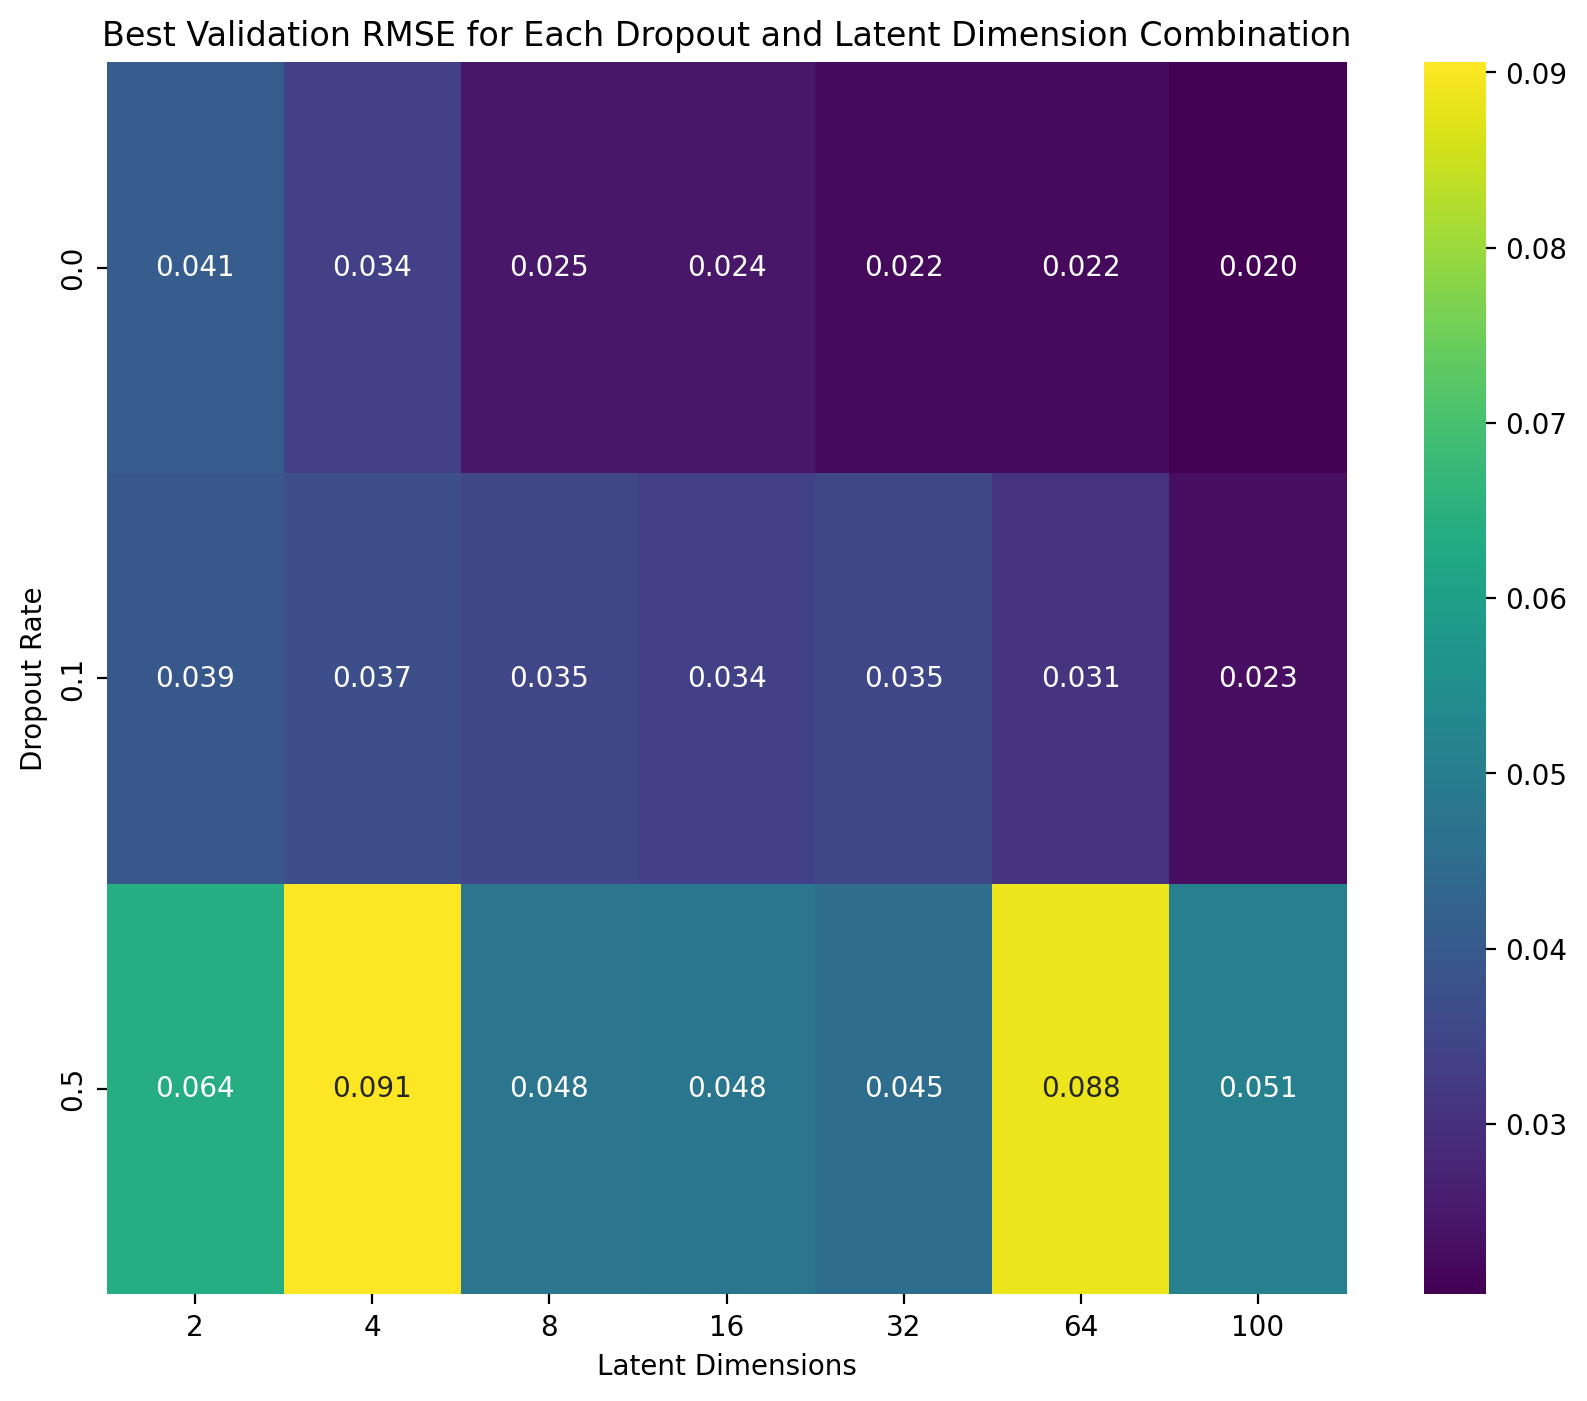

In [12]:
# Create a DataFrame with rows for dropout and columns for latent_dims
df_best_val = pd.DataFrame(index=dropout_values, columns=latent_dims)

# Populate the DataFrame with the best validation RMSE values
for latent_dim in latent_dims:
    for dropout in dropout_values:
         best_val_loss = results[(latent_dim, dropout)]["best_val_rmse"]
         df_best_val.loc[dropout, latent_dim] = best_val_loss

# Convert the values to floats (if they aren't already)
df_best_val = df_best_val.astype(float)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df_best_val, annot=True, fmt=".3f", cmap="viridis")
plt.xlabel("Latent Dimensions")
plt.ylabel("Dropout Rate")
plt.title("Best Validation RMSE for Each Dropout and Latent Dimension Combination")
plt.show()


In [13]:
#selecting the model with 64 latent dimensions, 0.1 dropout
sample = all_tracts_test_loader.dataset[0][0][0:1].to(device)
output = models[64, 0.1](sample)
print(sample.shape)

# Assuming the first element of the tuple is the reconstruction:
reconstructed = output[0]

orig = sample.cpu().detach().numpy()
recon = reconstructed.cpu().detach().numpy()


torch.Size([1, 50])


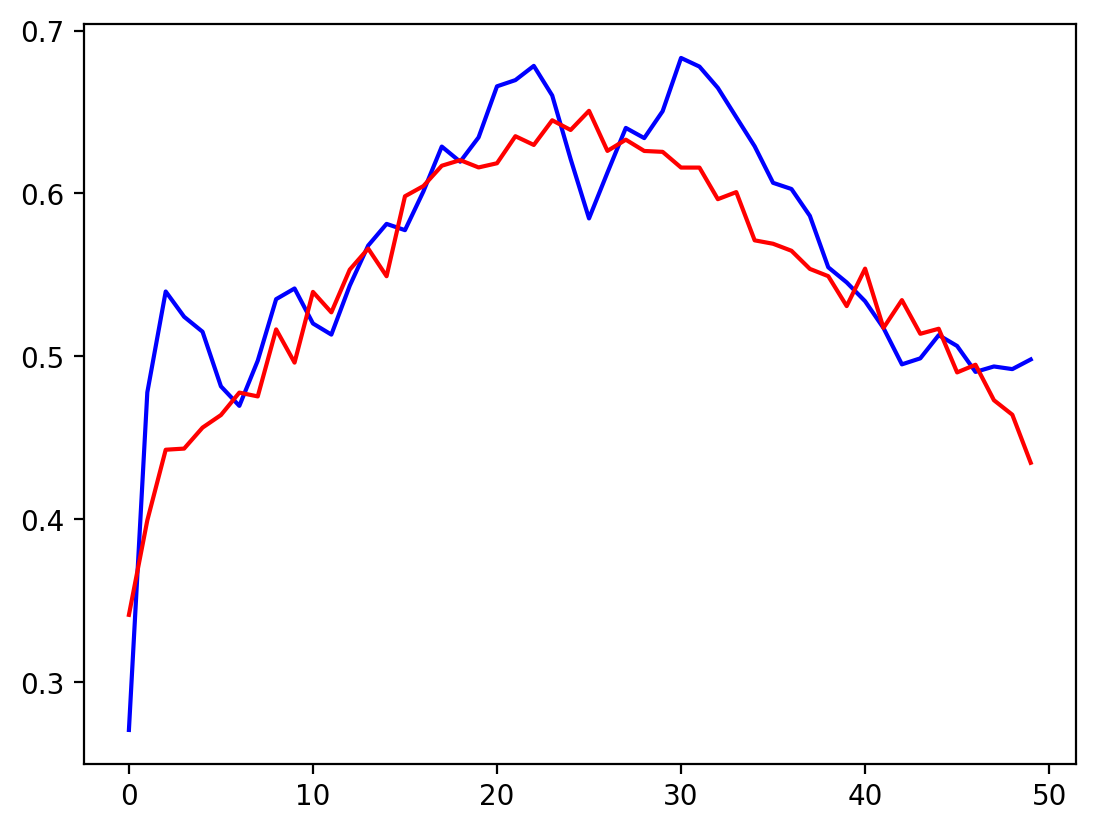

In [14]:
plt.plot(orig.flatten()[0:100], color='blue', label='Original')
plt.plot(recon.flatten()[0:100], color='red', label='Reconstructed')